In [1]:
library(OmnipathR)
# library(nichenetr)
library(tidyverse)
library(dplyr)
library(VennDiagram)
library(ggplot2)
library(utils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4      ✔ purrr   0.3.5 
✔ tibble  3.2.1      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: grid

Loading required package: futile.logger



```import_ligrecextra_interactions```

link: to documentation <https://r.omnipathdb.org/reference/import_ligrecextra_interactions.html>

This LR dataset contains ligand-receptor interactions without literature reference. The ligand-receptor interactions supported by literature references are part of the `omnipath` dataset.


Default params(without filtering resources) have 8350 edges. The table includes columns as follows. 

'source' 'target' 'source_genesymbol' 'target_genesymbol' 'is_directed' 'is_stimulation' 'is_inhibition' 'consensus_direction' 'consensus_stimulation' 'consensus_inhibition' 'sources' 'references' 'curation_effort' 'n_references' 'n_resources'

**The consensus score is if resources support the classification of an entity into a category based on combined information of many resources.**

| sources                                                         | ref | cur_effort | n_ref | n_source |
|-----------------------------------------------------------------|-----|------------|-------|----------|
|      Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019 | NA  | 0          | 0     | 3        |
| Baccin2019;CellCall;PhosphoPoint;Ramilowski2015_Baccin2019;Wang | NA  | 0          | 0     | 4        |
|                                                                 |     |            |       |          |

```curated_ligand_receptor_interactions```

expert curated ligand-receptor resources, provided by this function




# change LR to non-curated

In [2]:
# https://r.omnipathdb.org/reference/curated_ligand_receptor_interactions.html
# curated=curated_ligand_receptor_interactions()
lr <- import_ligrecextra_interactions()
lr <- lr %>% filter(!duplicated(lr[, c("source_genesymbol", "target_genesymbol")]))
lr$pair <- paste(lr$source_genesymbol, lr$target_genesymbol,sep="_")
lr$annotation_strategy <- "LR"


curated <- curated_ligand_receptor_interactions()
curated <- curated %>% filter(!duplicated(curated[, c("source_genesymbol", "target_genesymbol")]))
curated$pair <- paste(curated$source_genesymbol, curated$target_genesymbol,sep="_")
curated$annotation_strategy <- "curated"

In [3]:
# if pair is also in curatedDB, annotation_strategy should be both
lr <- lr %>%
      mutate(annotation_strategy = ifelse(pair %in% curated$pair, "both", annotation_strategy))

In [4]:
# curated[!curated$pair %in% lr$pair,]

In [5]:
both_db <- rbind(lr,curated)
both_db <- both_db[!duplicated(both_db$pair), ]

```import_omnipath_intercell``` Imports the OmniPath intercellular **communication role annotation** database. It provides information on the roles in inter-cellular signaling. E.g. if a protein is a ligand, a receptor, an extracellular matrix (ECM) component, etc.

In [6]:
anno_raw <- import_omnipath_intercell()
#subset annotation DB to only ligand and receptors
anno_lig <- anno_raw %>%
    dplyr::filter(category %in% c("receptor","ligand"))
# Drop rows where the values in the "parent", "database", and "uniprot" columns are duplicated
anno_raw <- anno_raw %>% filter(!duplicated(anno_raw[, c("parent", "database", "uniprot")]))

# Breaking down complexes

Below, we produce all the the possible pairs. 

Example: lets assume complex G1_G2_G3 is linked to another complex G4_G5_G6

| c1 | c2 | complex_origin    |
|----|----|-------------------|
| G1 | G2 | G1_G2_G3_G4_G5_G6 |
| G1 | G3 | G1_G2_G3_G4_G5_G6 |
| G1 | G4 | G1_G2_G3_G4_G5_G6 |
| G1 | G5 | G1_G2_G3_G4_G5_G6 |
| G1 | G6 | G1_G2_G3_G4_G5_G6 |
| G2 | G1 | G1_G2_G3_G4_G5_G6 |
| G2 | G3 | G1_G2_G3_G4_G5_G6 |
| .. | .. | G1_G2_G3_G4_G5_G6 |

In [7]:
# This function breaks down complex interactions and returns a list of components
# Input: OmniPath_DB
# Output: list of components of complex molecules

break_down_complex <- function(OmniPath_DB) {
    # filter only those are in complex
    complex <- filter(OmniPath_DB, grepl("COMPLEX", target) | grepl("COMPLEX", source))
    complex$source <- sub("COMPLEX:", "", complex$source)
    complex$target <- sub("COMPLEX:", "", complex$target)

    # complexes are seperated into individual components
    components_target <- unique(unlist(strsplit(complex$source_genesymbol, "_")))
    components_source <- unique(unlist(strsplit(complex$target_genesymbol, "_")))
    components_both <- c(components_target, components_source)
    components_both <- unique(components_both)
    return(list(components = components_both, complex = complex))
}

In [8]:
complex_components <- break_down_complex(both_db)

In [9]:
# This function takes the complex data frame and returns a data frame containing all possible pairwise pairs
# The function loops through each row of the complex data frame and extracts the values from the first and second
# columns. The loop then generates all the possible pairwise pairs using the combn function and appends the results
# to a list. The function then binds the results into a single data frame, switches the values in the source and target
# columns, and binds the rows into a single data frame. The function then drops the self links and returns the data frame.


create_pairwise_pairs <- function(complex){
    # Produce all the possbile pairwise pairs

    results <- list()

    # Loop through each row of the data frame
    for (i in 1:nrow(complex)) {
      # Extract the values from the first column
      values1 <- unlist(strsplit(as.character(complex[i, "source_genesymbol"]), "_"))
      # Extract the values from the second column
      values2 <- unlist(strsplit(as.character(complex[i, "target_genesymbol"]), "_"))
      # Keep the original pair
      original <- paste(complex[i, "source_genesymbol"],complex[i, "target_genesymbol"],sep="_")
      # Generate all the pairwise combinations using combn
      pairs <- combn(c(values1, values2), 2)
      pairs <- t(pairs)
      pairs <- cbind(pairs,original)
#       colnames(pairs) <- c("Ligand","Receptor","complex_pair")
      # Append the results to the list
      results[[i]] <- as.data.frame(pairs)
        colnames(results[[i]]) = c("source","target","complex_pair")
        row.names(results[[i]]) <- NULL
    }

    # Bind the results into a single data frame
    result_df2 <- as.data.frame(do.call(rbind, results))

    # Switch the values in the "col1" and "col2" columns
    df1 <- cbind(result_df2[,2], result_df2[,1], result_df2[,3])
    colnames(df1) <- names(result_df2)
    # Bind the rows into a single data frame
    result_df <- rbind(result_df2, df1)


    # Drop the self links
#     result_df <- result_df %>% filter(!duplicated(result_df[, c("source", "target")]))
    
    # create pairs column
    result_df$pair=paste(result_df$source, result_df$target,sep="_")
    
    return(result_df)
}

In [10]:
pairwise_pairs <- create_pairwise_pairs(complex_components$complex)

In [11]:
pairwise_pairs[!duplicated(pairwise_pairs$pair),]

,source,target,complex_pair,pair
,<chr>,<chr>,<chr>,<chr>
1,IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
2,IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
3,IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
4,NPNT,ITGA8,NPNT_ITGA8_ITGB1,NPNT_ITGA8
5,NPNT,ITGB1,NPNT_ITGA8_ITGB1,NPNT_ITGB1
6,ITGA8,ITGB1,NPNT_ITGA8_ITGB1,ITGA8_ITGB1
7,ITGAL,ITGB2,ITGAL_ITGB2_ICAM1,ITGAL_ITGB2
8,ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
9,ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1


In [12]:
pairwise_pairs <- create_pairwise_pairs(complex_components$complex)

In [13]:
length(unique(pairwise_pairs$pair))

[1] 3272

In [14]:
filter(pairwise_pairs, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A
IL17RC,IL17A,IL17A_IL17RA_IL17RC,IL17RC_IL17A
IL17RC,IL17RA,IL17A_IL17RA_IL17RC,IL17RC_IL17RA


# Linking through PPI

We are using the Omnipath intercellular interaction network, which is the largest available network of its kind, to detect interactions rather than make predictions. The creators of the network have noted that it may contain a large number of false positives. Despite this, we are using it in combination with an annotations database to detect interactions. The network has a size of 98,165 edges.

In [15]:
# Import All PPI
pt <- import_post_translational_interactions()

In [16]:
ppi_network=pt %>% filter(!duplicated(pt[, c("source_genesymbol", "target_genesymbol")]))

In [17]:
# create pairs, so its easier to check
ppi_network$pair=paste(ppi_network$source_genesymbol, ppi_network$target_genesymbol,sep="_")

## when filtering, print the difference in numbers

In [18]:
# The data frame result_df consists of all the pairwise pair combinations, 
# and we are checking if those pairs exist in the PT network
pt_interactions <- pairwise_pairs %>%
    filter(pair %in% ppi_network$pair)

str(pt_interactions)

'data.frame':	3042 obs. of  4 variables:
 $ source      : chr  "IL17A" "IL17A" "NPNT" "NPNT" ...
 $ target      : chr  "IL17RA" "IL17RC" "ITGA8" "ITGB1" ...
 $ complex_pair: chr  "IL17A_IL17RA_IL17RC" "IL17A_IL17RA_IL17RC" "NPNT_ITGA8_ITGB1" "NPNT_ITGA8_ITGB1" ...
 $ pair        : chr  "IL17A_IL17RA" "IL17A_IL17RC" "NPNT_ITGA8" "NPNT_ITGB1" ...


In [19]:
pt_interactions[!duplicated(pt_interactions$pair),]

,source,target,complex_pair,pair
,<chr>,<chr>,<chr>,<chr>
1,IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
2,IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
3,NPNT,ITGA8,NPNT_ITGA8_ITGB1,NPNT_ITGA8
4,NPNT,ITGB1,NPNT_ITGA8_ITGB1,NPNT_ITGB1
5,ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
6,ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1
7,ICAM1,ITGAL,ICAM1_ITGAL_ITGB2,ICAM1_ITGAL
8,ICAM1,ITGB2,ICAM1_ITGAL_ITGB2,ICAM1_ITGB2
9,VCAM1,ITGAD,VCAM1_ITGAD_ITGB2,VCAM1_ITGAD


In [20]:
head(pt_interactions)

,source,target,complex_pair,pair
,<chr>,<chr>,<chr>,<chr>
1,IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
2,IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
3,NPNT,ITGA8,NPNT_ITGA8_ITGB1,NPNT_ITGA8
4,NPNT,ITGB1,NPNT_ITGA8_ITGB1,NPNT_ITGB1
5,ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
6,ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1


**In below we demonstrate that all the possible pairs are produced orginating from the complex pair ```IL17A_IL17RA_IL17RC``` and through PT database, we filter out those does not exist in the PPI.**

In [21]:
filter(pairwise_pairs, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17RC,IL17A_IL17RA_IL17RC,IL17RA_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A
IL17RC,IL17A,IL17A_IL17RA_IL17RC,IL17RC_IL17A
IL17RC,IL17RA,IL17A_IL17RA_IL17RC,IL17RC_IL17RA


In [22]:
filter(pt_interactions, complex_pair=="IL17A_IL17RA_IL17RC")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
IL17A,IL17RA,IL17A_IL17RA_IL17RC,IL17A_IL17RA
IL17A,IL17RC,IL17A_IL17RA_IL17RC,IL17A_IL17RC
IL17RA,IL17A,IL17A_IL17RA_IL17RC,IL17RA_IL17A


In [23]:
filter(pairwise_pairs, complex_pair=="ITGAL_ITGB2_ICAM1")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
ITGAL,ITGB2,ITGAL_ITGB2_ICAM1,ITGAL_ITGB2
ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1
ITGB2,ITGAL,ITGAL_ITGB2_ICAM1,ITGB2_ITGAL
ICAM1,ITGAL,ITGAL_ITGB2_ICAM1,ICAM1_ITGAL
ICAM1,ITGB2,ITGAL_ITGB2_ICAM1,ICAM1_ITGB2


In [24]:
filter(pt_interactions, complex_pair=="ITGAL_ITGB2_ICAM1")

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
ITGAL,ICAM1,ITGAL_ITGB2_ICAM1,ITGAL_ICAM1
ITGB2,ICAM1,ITGAL_ITGB2_ICAM1,ITGB2_ICAM1
ICAM1,ITGAL,ITGAL_ITGB2_ICAM1,ICAM1_ITGAL
ICAM1,ITGB2,ITGAL_ITGB2_ICAM1,ICAM1_ITGB2


In [25]:
# hist(pairwise_pairs_lr$complex_pair, breaks=3, col="red")

In [26]:
table_data <- as.data.frame(table(pairwise_pairs$complex_pair))

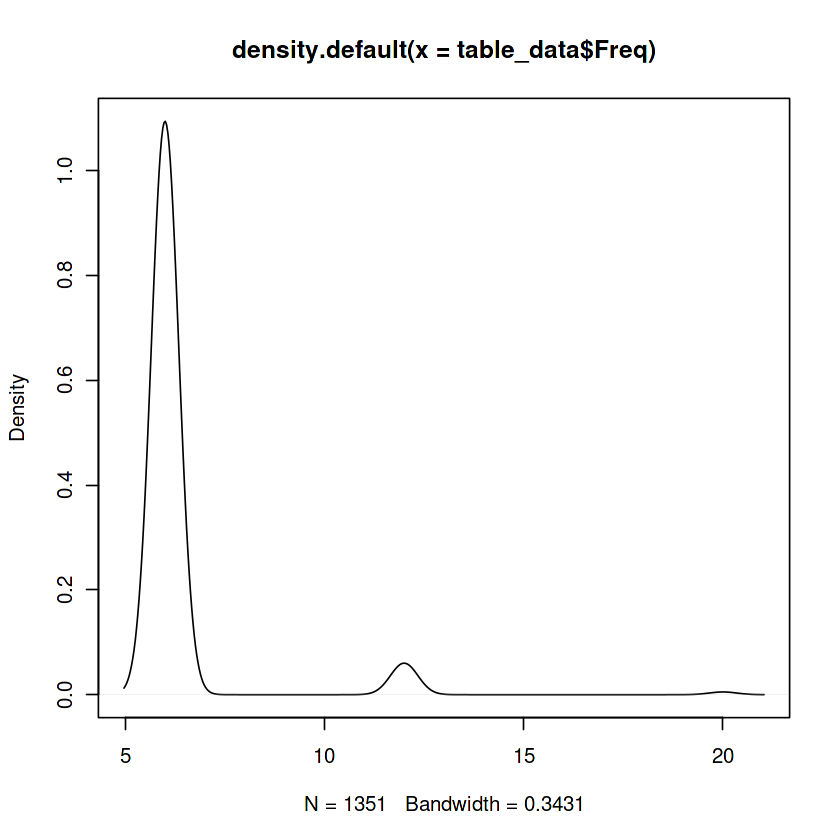

In [27]:
d <- density(table_data$Freq) # returns the density data
plot(d) # plots the results

In [28]:
table_data <- as.data.frame(table(pairwise_pairs$complex_pair))

In [29]:
jpeg(file="Number of binary pairs produced.jpeg")
table_data <- table(pairwise_pairs$complex_pair)
hist(table_data, main = "Number of binary pairs produced from complex", xlab = "# of binary originating from a single complex", ylab = "Count")
dev.off()

png 
  2

In [30]:
table_data <- as.data.frame(table(pt_interactions$complex_pair))

In [31]:
# pt_interactions[!duplicated(pt_interactions$pair),]

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Saving 6.67 x 6.67 in image


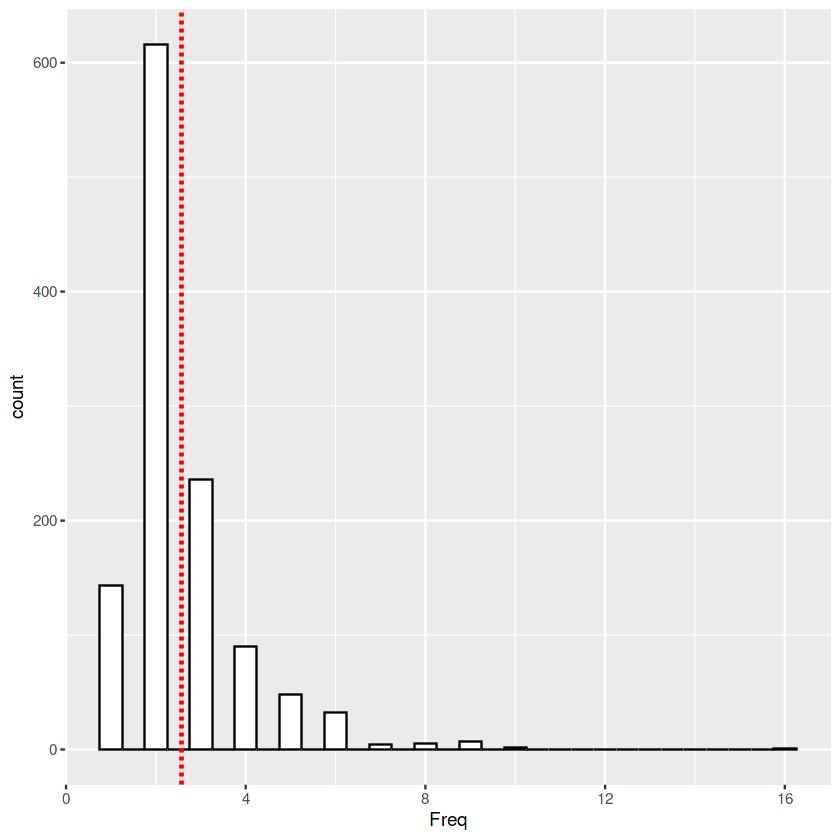

In [32]:
ggplot(table_data, aes(x=Freq)) +
    geom_histogram(binwidth=.5, colour="black", fill="white") +
    geom_vline(aes(xintercept=mean(Freq, na.rm=T)),   # Ignore NA values for mean
               color="red", linetype="dashed", size=1)
ggsave("binaries found.jpeg")

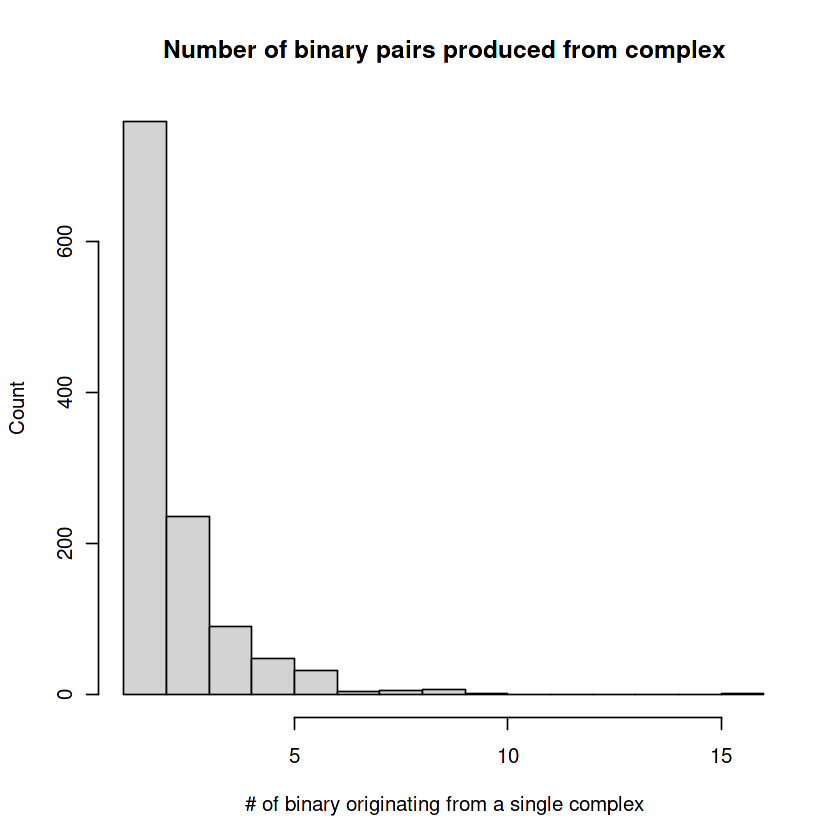

In [33]:
table_data <- table(pt_interactions$complex_pair)
hist(table_data, main = "Number of binary pairs produced from complex", xlab = "# of binary originating from a single complex", ylab = "Count")


# Complexes are broken down, now we can combine with the rest of the db

In [34]:
# This function merges the single components of the complexes that are detected through PPI_DB with 
# the single components of the complexes detected through OmniPath
# The function takes as input the OmniPath data frame and the pt_interactions (which the complex are broken down)

merge_single_complex <- function(OmniPath, pt_interactions){
    single_components = filter(OmniPath, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))
    
    single_components <- single_components %>%
      dplyr::select(source_genesymbol, target_genesymbol) %>%
      dplyr::rename(source=source_genesymbol, target=target_genesymbol) %>%
      dplyr::mutate(complex_pair = NA)    
    
    single_components$pair <- paste(single_components$source, single_components$target, sep="_")
    
    #merge the single ones, with complexes componenets that are detected via PT_DB
    complete <- rbind(single_components, pt_interactions)
    
    #remove the duplicated ones, and keep the last ones, which are coming from the complexes
    complete <- complete[ !duplicated(complete[, "pair"], fromLast=T),]
    
    return(complete)
}

In [35]:
# lr_binary=filter(both_db, !grepl('COMPLEX', target) & !grepl('COMPLEX',source))

In [36]:
# length(unique(lr_binary$pair))

In [37]:
lr_complex=filter(both_db, grepl('COMPLEX', target) | grepl('COMPLEX',source))

In [38]:
complete_lr <- merge_single_complex(both_db, pt_interactions)

In [39]:
complete_lr

source,target,complex_pair,pair
<chr>,<chr>,<chr>,<chr>
CALM1,TRPC3,NA,CALM1_TRPC3
S100A10,TRPV6,NA,S100A10_TRPV6
JAK2,EPOR,NA,JAK2_EPOR
NOTCH1,JAG2,NA,NOTCH1_JAG2
JAG2,NOTCH1,NA,JAG2_NOTCH1
DLL1,NOTCH1,NA,DLL1_NOTCH1
NOTCH1,DLL1,NA,NOTCH1_DLL1
IGF1,IGF1R,NA,IGF1_IGF1R
NOTCH1,JAG1,NA,NOTCH1_JAG1


# Gene Descriptions

We use mygene library to get the gene descriptions

In [40]:
library(mygene)

Loading required package: GenomicFeatures

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object is masked from ‘package:tidyr’:

    expand



In [41]:
# map_gene_descriptions function:
# 1. maps gene symbols to gene descriptions using the queryMany function
# 2. maps the protein descriptions to the dataset
# 3. reorders columns and renames columns

map_gene_descriptions <- function(complete) {
    # get gene symbols
    gene_symbols <- unique(c(complete$source,complete$target))
    
    prot_descriptions <- queryMany(gene_symbols, scopes = "symbol", 
                              fields = c("name"), 
                              species = "human", as_dataframe = "True")
    
    prot_descriptions <- as.data.frame(prot_descriptions)
    
    #map protein descriptions to complete set

    for (x in 1:nrow(complete)) {
        ligand_symbol=complete[x,]$source
        receptor_symbol=complete[x,]$target
        ligand_description=filter(prot_descriptions, query==ligand_symbol)$name
        receptor_description=filter(prot_descriptions, query==receptor_symbol)$name
        lig_id=filter(anno_raw, genesymbol==ligand_symbol)$uniprot[1]
        rec_id=filter(anno_raw, genesymbol==receptor_symbol)$uniprot[1]

        if (ligand_symbol=="PIK3CD-AS1") {
          lig_id <- "O00329"
        }

    #     if (is.null(receptor_description)) {
    #       receptor_description <- "NA"
    #     }


        complete[x, "ligand.name"] = ligand_description[1]
        complete[x, "receptor.name"] = receptor_description[1]
        complete[x, "partner_a"] = lig_id
        complete[x, "partner_b"] = rec_id
    }
    
    #reorder columns
    complete <- complete[, c("pair", "source", "ligand.name", "target", "receptor.name", "complex_pair",
                             "partner_a","partner_b")]
    #rename column names
    names(complete) <- c("Pair.Name", "Ligand", "Ligand.Name", "Receptor", "Receptor.Name", "complex_pair",
                        "partner_a","partner_b")
    
    return(complete)
}

In [42]:
complete_lr <- map_gene_descriptions(complete_lr)

Querying chunk 1

Querying chunk 2

Querying chunk 3



Finished
Pass returnall=TRUE to return lists of duplicate or missing query terms.


In [43]:
str(complete_lr)

tibble [7,415 × 8] (S3: tbl_df/tbl/data.frame)
 $ Pair.Name    : chr [1:7415] "CALM1_TRPC3" "S100A10_TRPV6" "JAK2_EPOR" "NOTCH1_JAG2" ...
 $ Ligand       : chr [1:7415] "CALM1" "S100A10" "JAK2" "NOTCH1" ...
 $ Ligand.Name  : chr [1:7415] "calmodulin 1" "S100 calcium binding protein A10" "Janus kinase 2" "notch receptor 1" ...
 $ Receptor     : chr [1:7415] "TRPC3" "TRPV6" "EPOR" "JAG2" ...
 $ Receptor.Name: chr [1:7415] "transient receptor potential cation channel subfamily C member 3" "transient receptor potential cation channel subfamily V member 6" "erythropoietin receptor" "jagged canonical Notch ligand 2" ...
 $ complex_pair : chr [1:7415] NA NA NA NA ...
 $ partner_a    : chr [1:7415] "P0DP23" "P60903" "O60674" "P46531" ...
 $ partner_b    : chr [1:7415] "Q13507" "Q9H1D0" "P19235" "Q9Y219" ...
 - attr(*, "origin")= chr "cache"


In [44]:
# filter(previous_db, Receptor=="NOTCH1")

In [45]:
c <- complete_lr

In [46]:
c

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
CALM1_TRPC3,CALM1,calmodulin 1,TRPC3,transient receptor potential cation channel subfamily C member 3,NA,P0DP23,Q13507
S100A10_TRPV6,S100A10,S100 calcium binding protein A10,TRPV6,transient receptor potential cation channel subfamily V member 6,NA,P60903,Q9H1D0
JAK2_EPOR,JAK2,Janus kinase 2,EPOR,erythropoietin receptor,NA,O60674,P19235
NOTCH1_JAG2,NOTCH1,notch receptor 1,JAG2,jagged canonical Notch ligand 2,NA,P46531,Q9Y219
JAG2_NOTCH1,JAG2,jagged canonical Notch ligand 2,NOTCH1,notch receptor 1,NA,Q9Y219,P46531
DLL1_NOTCH1,DLL1,delta like canonical Notch ligand 1,NOTCH1,notch receptor 1,NA,O00548,P46531
NOTCH1_DLL1,NOTCH1,notch receptor 1,DLL1,delta like canonical Notch ligand 1,NA,P46531,O00548
IGF1_IGF1R,IGF1,insulin like growth factor 1,IGF1R,insulin like growth factor 1 receptor,NA,P05019,P08069
NOTCH1_JAG1,NOTCH1,notch receptor 1,JAG1,jagged canonical Notch ligand 1,NA,P46531,P78504


# append the original structure from OmniPath

Create a column to merge with. We are doing this because the complex pairs in our data have been broken down, while they are not broken down in the original data. The new column will allow us to match and merge the broken-down pairs with the corresponding pairs in the original data

In [48]:
# colnames(x)

In [49]:
# If the complex pair is not NA, return the complex pair under the to_merge column. 
# else return the ligand and receptor names separated by an underscore
complete_lr <- complete_lr %>% mutate(to_merge = ifelse(!is.na(complex_pair), complex_pair,
                                                  paste(Ligand, Receptor, sep="_")))

In [50]:
x=as.data.frame(merge(complete_lr, both_db, by.x = "to_merge", by.y = "pair"))

In [51]:
both_db

source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,pair,annotation_strategy
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
P0DP23,Q13507,CALM1,TRPC3,1,0,1,1,0,1,CellTalkDB;Fantom5_LRdb;HPRD;HPRD_LRdb;LRdb;TRIP;iTALK,CellTalkDB:11248050;HPRD:15104175;TRIP:11248050;TRIP:11290752;TRIP:12601176;TRIP:18215135,6,5,5,CALM1_TRPC3,both
P60903,Q9H1D0,S100A10,TRPV6,1,1,0,1,1,0,CellTalkDB;HPRD;TRIP,CellTalkDB:18187190;HPRD:12660155;TRIP:12660155;TRIP:16189514;TRIP:18187190,5,3,3,S100A10_TRPV6,both
O60674,P19235,JAK2,EPOR,1,1,0,1,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoNetworks;PhosphoPoint;PhosphoSite_KEA;PhosphoSite_MIMP;ProtMapper;SIGNOR;SIGNOR_ProtMapper;SPIKE;Wang;iPTMnet;phosphoELM;phosphoELM_KEA;phosphoELM_MIMP,BioGRID:8343951;Cellinker:9030561;HPRD-phos:12441334;HPRD:11779507;HPRD:12441334;HPRD:8343951;KEA:10579919;KEA:10660611;KEA:11443118;KEA:12027890;KEA:12441334;KEA:7559499;KEA:9573010;ProtMapper:12441334;ProtMapper:15212693;SIGNOR:12441334;SPIKE:12524467;SPIKE:18672044;iPTMnet:10579919;iPTMnet:12441334;phosphoELM:10579919,21,13,14,JAK2_EPOR,LR
P46531,Q9Y219,NOTCH1,JAG2,1,0,1,0,0,0,Baccin2019;CellCall;HPRD;NetPath;Ramilowski2015_Baccin2019;SPIKE,HPRD:11006133;NetPath:11006133;SPIKE:15358736,3,2,5,NOTCH1_JAG2,LR
Q9Y219,P46531,JAG2,NOTCH1,1,1,1,1,1,0,Baccin2019;CellCall;CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DLRP_Cellinker;DLRP_talklr;EMBRACE;Fantom5_LRdb;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;ICELLNET;KEGG-MEDICUS;Kirouac2010;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;SignaLink3;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:1100613311006130;CellChatDB:22353464;CellPhoneDB:22353464;CellTalkDB:22353464;Cellinker:11006133;Cellinker:22353464;HPRD:11006133;ICELLNET:16921404;ICELLNET:21352254;ICELLNET:22503540;LRdb:11006133;NetPath:11006133;SIGNOR:9315665;SignaLink3:10958687;SignaLink3:11006133;SignaLink3:18988627;SignaLink3:21071413;SignaLink3:23331499;connectomeDB2020:11006133,19,11,20,JAG2_NOTCH1,both
O00548,P46531,DLL1,NOTCH1,1,1,0,1,1,0,Baccin2019;CellCall;CellChatDB;CellPhoneDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DLRP_Cellinker;DLRP_talklr;EMBRACE;Fantom5_LRdb;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;ICELLNET;KEGG-MEDICUS;Kirouac2010;LRdb;NetPath;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;SPIKE;STRING_talklr;UniProt_LRdb;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:1006133;Baccin2019:98194281;CellChatDB:22353464;CellPhoneDB:22353464;CellTalkDB:22353464;Cellinker:11006133;Cellinker:22353464;Cellinker:9819428;HPRD:11006133;ICELLNET:21685328;LRdb:11;LRdb:9819428;NetPath:11006133;SIGNOR:16140393;SPIKE:11006133;SPIKE:17537801;connectomeDB2020:11006133;connectomeDB2020:9819428,18,9,20,DLL1_NOTCH1,both
P46531,O00548,NOTCH1,DLL1,1,1,1,0,0,0,Baccin2019;CellCall;HPRD;NetPath;Ramilowski2015_Baccin2019;SPIKE;SignaLink3;Wang,Baccin2019:11006133;HPRD:11006133;NetPath:11006133;SPIKE:11006133;SPIKE:15358736;SPIKE:17537801;SignaLink3:21985982,7,4,7,NOTCH1_DLL1,LR
P05019,P08069,IGF1,IGF1R,1,1,0,1,1,0,Baccin2019;CA1;CellCall;CellChatDB;CellPhoneDB;CellTalkDB;Cellinker;DIP;DLRP_Cellinker;DLRP_talklr;EMBRACE;Fantom5_LRdb;Guide2Pharma;Guide2Pharma_Cellinker;Guide2Pharma_LRdb;Guide2Pharma_talklr;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;IntAct;KEGG-MEDICUS;Kirouac2010;LRdb;ProtMapper;REACH_ProtMapper;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;SPIKE;STRING_talklr;SignaLink3;Sparser_ProtMapper;UniProt_LRdb;Wang;connectomeDB2020;iTALK;scConnect;talklr,Baccin2019:1852007;Baccin2019:2877871;CA1:8408032;CellChatDB:14604834;CellTalkDB:2877871;Cellinker:14604834;Cellinker:1852007;Cellinker:2877871;DIP:11287679;DIP:21645859;H

In [52]:
complete_lr=as.data.frame(merge(complete_lr, both_db, by.x = "to_merge", by.y = "pair"))

In [53]:
# Remove the columns that were used to merge the data
complete_lr <- complete_lr %>% dplyr::select(-to_merge)

In [54]:
complete_lr <- complete_lr[!duplicated(complete_lr$Pair.Name),]

In [55]:
#this column is needed when building CellPhoneDB
# concatanated$annotation_strategy <- ifelse(concatanated$curated == TRUE, "OmniPath_curated", "OmniPath")

In [56]:
write.csv(complete_lr, "L_R_reviseD_full_before_fix.csv", row.names=FALSE)

In [57]:
# complete = read.csv('L_R_reviseD_full_before_fix.csv')

In [58]:
filter(complete_lr,Ligand=="PIK3CD-AS1")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
PIK3CD-AS1_LY6G6C,PIK3CD-AS1,PIK3CD antisense RNA 1,LY6G6C,lymphocyte antigen 6 family member G6C,NA,O00329,O95867,Q5SR53,O95867,⋯,0,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR
PIK3CD-AS1_SLC16A4,PIK3CD-AS1,PIK3CD antisense RNA 1,SLC16A4,solute carrier family 16 member 4,NA,O00329,O15374,Q5SR53,O15374,⋯,0,0,0,0,Fantom5_LRdb;LRdb;iTALK,NA,0,0,2,LR


In [59]:
complete_lr$Ligand <- str_replace(complete_lr$Ligand, "PIK3CD-AS1", "PIK3CD")

In [ ]:
complete_lr$Pair.Name <- paste(complete_lr$Ligand, complete_lr$Receptor, sep="_")

In [ ]:
complete_lr$dup <- paste(complete_lr$Receptor, complete_lr$Ligand, sep="_")

# Annotation of components

The Omnipath Intercell annotation database is imported and used to annotate each component. If at least two databases categorize a component as a ligand or receptor, it is annotated as such. If not, we check other possible categories such as extracellular matrix, secreted, and transmembrane. Below is the list of resources used to annotote.

In [ ]:
get_intercell_resources()

In [ ]:
# This function is to annotate the components from the PPI network with their parent category
# The input of this function is a df with columns of "genesymbol", "score", "parent"
# The output of this function is a df with columns of "genesymbol", "score", "parent"
# This function is used to annotate the components from the PPI network with their parent category

annotate_components <- function(components) {
    #create a df to store annotation
    df <- data.frame(genesymbol = character(length(components)), score = numeric(length(components)),
                     parent = character(length(components)), stringsAsFactors = FALSE)
    
    # Check if the components are categorized as ligands or receptors
    for (x in 1:length(components)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genename <- components[x]
        parent_score <- sort(table(filter(anno_lig, genesymbol==components[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        if (is.null(parent_category)) {
          parent_category <- "NA"
          parent_score <- 0
        }

        df[x, "genesymbol"] <- genename
        df[x, "score"] <- parent_score
        df[x, "parent"] <- parent_category

    #     df$genesymbol[x] <- genename
    #     df$score[x] <- parent_score
    #     df$parent[x] <- parent_category
    }
    
    # If a component is not classified as a ligand or receptor, we may consider other categories such as 
    # extracellular matrix, secreted, and transmembrane.# annotated others such as secreted, ecm etc

    df_na <- filter(df, parent=="NA")$genesymbol

    for (x in 1:length(df_na)) {
    #     maxvalue=max(filter(anno, uniprot==components[x])$consensus_score)
        genesymbol <- df_na[x]
        parent_score <- sort(table(filter(anno_raw, genesymbol==df_na[x])$parent), decreasing = T, na.last = T)[1]
        parent_category <- names(parent_score)

        df <- df %>% mutate(parent = ifelse(genesymbol == df_na[x], parent_category, parent))
        df <- df %>% mutate(score = ifelse(genesymbol == df_na[x], parent_score, score))

    }
    
    # replace ecm and secreted with ligand
    df$parent <- replace(df$parent, df$parent == "ecm", "ligand")
    df$parent <- replace(df$parent, df$parent == "secreted", "ligand")
    
    return(df)

}

In [ ]:
components <- unique(c(complete_lr$Ligand, complete_lr$Receptor))

In [ ]:
annotation <- annotate_components(components)

In [ ]:
unique(annotation$parent)

In [ ]:
# ggplot(true_LR, aes(x=score)) +
#     geom_histogram(binwidth=.5, colour="black", fill="white") +
#     geom_vline(aes(xintercept=mean(score, na.rm=T)),   # Ignore NA values for mean
#                color="red", linetype="dashed", size=1)

In [ ]:
#TRUE LR genespace
true_LR_anno <- filter(annotation, parent == "receptor" | parent == "ligand")
# true_LR_genespace <- true_LR_anno$genesymbol

In [ ]:
annotation[annotation$genesymbol=="BMPR1B",]

In [ ]:
adhesive_genespace <- filter(annotation, !genesymbol %in% true_LR_anno$genesymbol)

In [ ]:
ligands <- filter(true_LR, parent=="ligand")$genesymbol
receptors <- filter(true_LR, parent=="receptor")$genesymbol

In [ ]:
# Filter the LR pairs that are not in the correct direction
# Exclude the pairs if the swapped (correct direction) counterparts exist in the database

LR_fix_dir <- complete_lr %>% 
  filter(Ligand %in% receptors & Receptor %in% ligands) #%>% 
  #anti_join(complete, by = c("dup" = "Pair.Name"))
#     filter(!dup %in% complete$Pair.Name)

In [ ]:
annotation[annotation$genesymbol=="BMP15",]

In [ ]:
complete_lr <- filter(complete_lr, !Pair.Name %in% LR_fix_dir$Pair.Name)

In [ ]:
7415 - nrow(complete_lr) == nrow(LR_fix_dir)

In [ ]:
#fix the directions
LR_fix_dir[, c("Ligand", "Receptor", "Ligand.Name", "Receptor.Name",
      "partner_a","partner_b", "source","target","source_genesymbol","target_genesymbol")] <- LR_fix_dir[, c("Receptor", "Ligand", "Receptor.Name", "Ligand.Name",
                                                                                                    "partner_b","partner_a", "target","source","target_genesymbol","source_genesymbol")]

LR_fix_dir["Pair.Name"] <- paste(LR_fix_dir$Ligand, LR_fix_dir$Receptor, sep="_")
LR_fix_dir["dup"] <- paste(LR_fix_dir$Receptor, LR_fix_dir$Ligand, sep="_")

In [72]:
# these are the list of interactions that are strictly in LR direction
true_LR_DB <- complete_lr %>% filter(Ligand %in% ligands & Receptor %in% receptors)

In [73]:
complete_lr <- filter(complete_lr, !Pair.Name %in% true_LR_DB$Pair.Name)

In [74]:
true_LR_DB["True_LR"]=TRUE

In [75]:
LR_fix_dir["True_LR"]=TRUE

In [76]:
true_LR_DB <- rbind(true_LR_DB,LR_fix_dir)

In [78]:
adhesive_DB <- filter(complete_lr, !Pair.Name %in% true_LR_DB$Pair.Name)

In [80]:
nrow(adhesive_DB) == nrow(complete_lr)

[1] TRUE

In [81]:
adhesive_DB["True_LR"]=FALSE

In [83]:
nrow(true_LR_DB) + nrow (adhesive_DB)

[1] 7415

In [84]:
reversed <- adhesive_DB[adhesive_DB$dup %in% adhesive_DB$Pair.Name,  ]

In [85]:
# check if any of them in true_LR, it should not
filter(reversed, dup %in% true_LR_DB$Pair.Name)

Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”
Warning message in cbind(parts$left, ellip_h, parts$right, deparse.level = 0L):
“number of rows of result is not a multiple of vector length (arg 2)”


Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>


In [144]:
# reversed <- adhesive_DB[adhesive_DB$dup %in% adhesive_DB$Pair.Name,  ]

In [145]:
# adhesive_DB <- adhesive_DB[!adhesive_DB$dup %in% true_LR_DB$Pair.Name,  ]

In [86]:
nrow(adhesive_DB)

[1] 2955

In [87]:
# remove the subsetted partition from the original df
adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% reversed$Pair.Name,  ]

In [89]:
2955-nrow(reversed) == nrow(adhesive_DB)

[1] TRUE

In [148]:
# true_LR_DB <- filter(true_LR_DB, !Pair.Name %in% reversed_found_in_LR$dup)

In [90]:
nrow(reversed)

[1] 342

In [228]:
nrow(adhesive_DB)

[1] 2613

In [91]:
# Extract all the unique proteins/genes from the subset_lr data frame that have "plexin",
# "neuroligin" or "ADAM" in their Receptor.Name column
# these will be corrected as ligands

plexin_family <- as.vector(reversed[grep("plexin", reversed$Receptor.Name), ]$Receptor)

neuroligin_family <- as.vector(reversed[grep("neuroligin", reversed$Receptor.Name), ]$Receptor)

adam_family <- as.vector(reversed[grep("ADAM", reversed$Receptor.Name), ]$Receptor)

#extract receptors that has annotation of "receptor" under Ligand.Name
receptor_anno <- as.vector(reversed[grep("receptor", reversed$Ligand.Name), ]$Ligand)

In [92]:
ligand <- c("AGRN", "BMP2", "BMP4", "VTCN1", "CD244", "CD38", "GAS6", "GDNF", "GUCA2A", 
"HHLA2", "IHH", "PSEN1", "NLGN", "NRTN", "RPH3A", "SHH","FLT3LG")

receptor <- c("CD2", "CD27", "CD80", "CD86", "SELL", "CD44", "CD81", "CD8A", "CLEC1B", 
"GLG1", "TYROBP", "FLT3", "ERBB2", "EGFR", "IL1R1", "IL1RAP", "KDR", "NRP1")

In [96]:
# Combine the additional ligands with the plexin, neuroligin, and ADAM families into a vector called ligand
ligand <- unique(c(ligand,plexin_family,neuroligin_family,adam_family))
receptor <- unique(c(receptor,receptor_anno))

In [98]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 1
dir <- reversed %>% filter(Pair.Name %in% reversed$dup & consensus_direction == 1)

In [99]:
# Subset the subset_lr data frame to only include rows where the consensus_direction column is 0
no_dir <- reversed %>% filter(Pair.Name %in% reversed$dup & consensus_direction == 0)

In [104]:
nrow(no_dir) + nrow(dir) == nrow(reversed)

[1] TRUE

In [108]:
# # Remove rows from no_dir where the pair is already present in dir
# in_dir1 <- dir[dir$dup %in% no_dir$Pair.Name,] 
# no_dir1 <- no_dir[!no_dir$Pair.Name %in% dir$dup,  ] #removal of those in dir below is rm of nodir
# # dir <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,] # did not work thats why there is below no fucking idea

In [109]:
# Remove rows from no_dir where the pair is already present in dir
in_dir <- dir[dir$dup %in% no_dir$Pair.Name,] 
no_dir <- no_dir[!no_dir$Pair.Name %in% in_dir$dup,  ] #removal of those in dir below is rm of nodir
# dir <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,] # did not work thats why there is below no fucking idea

In [116]:
dir <- dir[!dir$Pair.Name %in% in_dir$Pair.Name,]

In [117]:
# remove the interactions where receptor is annotated as ligand
wrong_lig <- no_dir[no_dir$Receptor %in% ligand,]
correct_lig <- no_dir[no_dir$dup %in% wrong_lig$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_lig$Pair.Name, correct_lig$Pair.Name),]

In [118]:
# wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
# wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]

In [119]:
# remove the interactions where receptor is annotated as ligand
wrong_rec <- no_dir[no_dir$Ligand %in% receptor,]
wrong_rec <- wrong_rec[!wrong_rec$Pair.Name %in% wrong_rec$dup,]
correct_rec <- no_dir[no_dir$dup %in% wrong_rec$Pair.Name,]
no_dir <- no_dir[!no_dir$Pair.Name %in% c(wrong_rec$Pair.Name, correct_rec$Pair.Name),]

In [120]:
nrow(no_dir)

[1] 108

In [121]:
# remove the interactions where receptor is annotated as ligand
# no_dir <- no_dir[!no_dir$Receptor %in% ligand,]

In [122]:
# remove the interactions where ligand is annotated as receptor
# no_dir <- no_dir[!no_dir$Ligand %in% receptor,]

In [123]:
# wrong_lig <- no_dir[no_dir$Receptor %in% ligand,]

In [124]:
# Create an empty data frame called df with the same column names as no_dir
df <- data.frame(matrix(ncol = ncol(no_dir), nrow = 0))
col_names <- colnames(no_dir)
colnames(df) <- col_names

In [125]:
filter(no_dir, Ligand=="ABCA1" | Receptor == "ABCA1")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,SHANK1_ABCA1,FALSE
SHANK1_ABCA1,SHANK1,SH3 and multiple ankyrin repeat domains 1,ABCA1,ATP binding cassette subfamily A member 1,NA,Q9Y566,O95477,Q9Y566,O95477,⋯,0,0,Baccin2019;CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;iTALK;talklr,Baccin2019:16192279;HPRD:16192279;LRdb:16192279,3,1,8,LR,ABCA1_SHANK1,FALSE


In [128]:
# Function to lexographically sort the gene pairs
sort_pairs <- function(pair) {
  parts <- strsplit(pair, "_")[[1]]
  sorted_parts <- sort(parts)
  return(paste(sorted_parts, collapse = "_"))
}

In [129]:
# Apply the function to the Pair.Name column
no_dir$Pair.Name <- sapply(no_dir$Pair.Name, sort_pairs)

In [135]:
no_dir %>% distinct(Pair.Name, .keep_all = TRUE)

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,dup,True_LR
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
ABCA1_SHANK1,ABCA1,ATP binding cassette subfamily A member 1,SHANK1,SH3 and multiple ankyrin repeat domains 1,NA,O95477,Q9Y566,O95477,Q9Y566,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:16192279,1,1,2,LR,SHANK1_ABCA1,FALSE
ADRA2A_GNAI2,ADRA2A,adrenoceptor alpha 2A,GNAI2,G protein subunit alpha i2,NA,P08913,P04899,P08913,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:7887906,1,1,2,LR,GNAI2_ADRA2A,FALSE
ADRA2B_GNAI2,ADRA2B,adrenoceptor alpha 2B,GNAI2,G protein subunit alpha i2,NA,P18089,P04899,P18089,P04899,⋯,0,0,Baccin2019;HPRD;Ramilowski2015_Baccin2019,HPRD:2169434,1,1,2,LR,GNAI2_ADRA2B,FALSE
ALCAM_L1CAM,ALCAM,activated leukocyte cell adhesion molecule,L1CAM,L1 cell adhesion molecule,NA,Q13740,P32004,Q13740,P32004,⋯,0,0,Baccin2019;connectomeDB2020,Baccin2019:22983139;connectomeDB2020:31300520,2,2,2,both,L1CAM_ALCAM,FALSE
AMHR2_BMPR1B,BMPR1B,bone morphogenetic protein receptor type 1B,AMHR2,anti-Mullerian hormone receptor type 2,AMH_AMHR2_BMPR1B,O00238,Q16671,P03971,COMPLEX:O00238_Q16671,⋯,0,0,CellPhoneDB;CellPhoneDB_Cellinker;Cellinker,CellPhoneDB:22710174;Cellinker:22710174,2,1,2,both,AMHR2_BMPR1B,FALSE
APP_BACE1,BACE1,beta-secretase 1,APP,amyloid beta precursor protein,APP_BACE1_TNFRSF21,P56817,P05067,COMPLEX:P05067_P56817,O75509,⋯,0,0,Baccin2019,Baccin2019:19225519,1,1,1,LR,APP_BACE1,FALSE
APP_CAV1,APP,amyloid beta precursor protein,CAV1,caveolin 1,NA,P05067,Q03135,P05067,Q03135,⋯,0,0,CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;connectomeDB2020;iTALK;talklr,CellTalkDB:9553108;HPRD:9553108;LRdb:9553108;connectomeDB2020:9553108,4,1,8,both,CAV1_APP,FALSE
APP_GPC1,APP,amyloid beta precursor protein,GPC1,glypican 1,NA,P05067,P35052,P05067,P35052,⋯,0,0,CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;STRING_talklr;connectomeDB2020;iTALK;talklr,CellTalkDB:15084524;HPRD:15084524;LRdb:15084524;connectomeDB2020:15084524,4,1,8,both,GPC1_APP,FALSE
APP_NCSTN,APP,amyloid beta precursor protein,NCSTN,nicastrin,NA,P05067,Q92542,P05067,Q92542,⋯,0,0,CancerCellMap;CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;Ramilowski2015;connectomeDB2020;iTALK;talklr,CancerCellMap:12011466;CellTalkDB:10993067;HPRD:10993067;LRdb:10993067;connectomeDB2020:10993067,5,2,9,both,NCSTN_APP,FALSE


In [268]:
# Loop through unique ligands in the no_dir data frame
for (lig in unique(no_dir$Ligand)) {
    vec_clean <- vector()
    # Filter the no_dir data frame to include only rows where Ligand or Receptor column matches the current ligand in the loop
    # this yields the pairs that are swapped.
    r1 <- filter(no_dir, Ligand==lig | Receptor == lig)
#     print(lig)
#     print(nrow(r1))
    vec <- r1$Pair.Name
    
    for (component in vec) {
        comp <- unlist(strsplit(component, split = "_"))
        pair1 <- paste(comp[1], comp[2], sep = "_")
        pair2 <- paste(comp[2], comp[1], sep = "_")
        
        if (!pair1 %in% vec_clean & !pair2 %in% vec_clean) {
            vec_clean <- append(vec_clean, pair1)
        }
    }
    
    # Filter the r1 data frame to include only the unique pairs in vec_clean and append the resulting data frame to df
    c1 <- r1[r1$Pair.Name %in% vec_clean,]
    
    df <- rbind(df,c1)
}

In [277]:
no_dir_df <- df[!duplicated(df$Pair.Name),]

In [278]:
nrow(no_dir_df)

[1] 54

In [279]:
# Combine the dir and no_dir_df data frames
subset_lr <- rbind(dir,no_dir_df,in_dir,correct_lig,correct_rec)

In [280]:
subset_lr["True_LR"] <- FALSE

In [281]:
# Add the remaining rows of LR_database to subset_lr
adhesive_DB <- rbind(subset_lr,adhesive_DB)

In [176]:
# dir_fix <- c("ERBB2_EGFR", "IL1RAP_IL1R1", "NRP1_KDR")

In [177]:
# adhesive_DB <- adhesive_DB[!adhesive_DB$Pair.Name %in% dir_fix,  ]

In [178]:
# adhesive_DB <- adhesive_DB[,!names(adhesive_DB) == "dup"]

In [282]:
LR_database <- rbind(true_LR_DB, adhesive_DB)

In [153]:
# found_in_LR["True_LR"]<- TRUE

In [154]:
LR_database <- rbind(true_LR_DB, adhesive_DB,found_in_LR)

ERROR: Error in eval(quote(list(...)), env): object 'found_in_LR' not found


In [181]:
LR_database <- LR_database[!LR_database$Pair.Name %in% found_in_LR$dup,]

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'table' in selecting a method for function '%in%': object 'found_in_LR' not found


In [285]:
LR_database <- LR_database[!duplicated(LR_database$Pair.Name),]

In [288]:
#update the complex_pair columns
pairwise_pairs <- pairwise_pairs[!duplicated(pairwise_pairs$pair),]
colnames(pairwise_pairs)[4] <- "Pair.Name"



LR_database <- LR_database %>%
  mutate(complex_pair = coalesce(pairwise_pairs$complex_pair[match(Pair.Name, pairwise_pairs$Pair.Name)], complex_pair))

In [185]:
LR_database <- LR_database[,!names(LR_database) == "dup"]

In [187]:
LR_database_post <- LR_database

In [413]:
write.csv(LR_database, "LR_database.csv", row.names=FALSE)

In [414]:
save(LR_database, file = "LR_database.rda")

In [188]:
library(community)

In [190]:
data(LR_database)

In [195]:
LR_database_post[!LR_database_post$Pair.Name %in% LR_database$Pair.Name,]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<lgl>
16100,BMPR2_BMPR1A,BMPR2,bone morphogenetic protein receptor type 2,BMPR1A,bone morphogenetic protein receptor type 1A,BMP2_BMPR1A_BMPR2,Q13873,P36894,Q13145,COMPLEX:P36894_Q13873,⋯,1,0,1,CellChatDB-cofactors,NA,0,0,1,LR,FALSE
18100,BMPR2_BMPR1B,BMPR2,bone morphogenetic protein receptor type 2,BMPR1B,bone morphogenetic protein receptor type 1B,BMP15_BMPR1B_BMPR2,Q13873,O00238,Q13145,COMPLEX:O00238_Q13873,⋯,1,0,1,CellChatDB-cofactors,NA,0,0,1,LR,FALSE
20100,TGFBR1_TGFBR2,TGFBR1,transforming growth factor beta receptor 1,TGFBR2,transforming growth factor beta receptor 2,TGFB1_TGFBR1_TGFBR2,P36897,P37173,Q13145,COMPLEX:P36897_P37173,⋯,1,0,1,CellChatDB-cofactors,NA,0,0,1,LR,FALSE
29100,ACVR2A_ACVRL1,ACVR2A,activin A receptor type 2A,ACVRL1,activin A receptor like type 1,BMP10_ACVR2A_ACVRL1,P27037,P37023,P17813,COMPLEX:P27037_P37023,⋯,1,1,0,CellChatDB-cofactors,NA,0,0,1,LR,FALSE
39100,KDR_FLT1,KDR,kinase insert domain receptor,FLT1,fms related receptor tyrosine kinase 1,VEGFA_FLT1_KDR,P35968,P17948,O60462,COMPLEX:P17948_P35968,⋯,1,1,0,CellChatDB-cofactors,NA,0,0,1,LR,FALSE
41100,KDR_FLT4,KDR,kinase insert domain receptor,FLT4,fms related receptor tyrosine kinase 4,VEGFC_FLT4_KDR,P35968,P35916,O60462,COMPLEX:P35916_P35968,⋯,1,1,0,CellChatDB-cofactors,NA,0,0,1,LR,FALSE
7100,BACE1_APP,BACE1,beta-secretase 1,APP,amyloid beta precursor protein,APP_BACE1_PSEN1_FPR2,P56817,P05067,COMPLEX:P05067_P56817,O75509,⋯,0,0,0,Baccin2019,Baccin2019:19225519,1,1,1,LR,FALSE
13810,IL23R_IL12RB1,IL23R,interleukin 23 receptor,IL12RB1,interleukin 12 receptor subunit beta 1,IL12B_IL23A_IL12RB1_IL23R,Q5VWK5,P42701,Q9NPF7,COMPLEX:P42701_Q5VWK5,⋯,0,0,0,Cellinker;HPMR_Cellinker,Cellinker:11114383;Cellinker:12023369;Cellinker:12671732;Cellinker:30995503,4,4,1,LR,FALSE
14410,CD8B_LCK,CD8B,CD8 subunit beta,LCK,"LCK proto-oncogene, Src family tyrosine kinase",LCK_CD8A_CD8B,P10966,P06239,P06239,COMPLEX:P01732_P10966,⋯,0,0,0,CellChatDB;CellPhoneDB;Cellinker,CellChatDB:25427562;Cellinker:25427562,2,1,3,curated,FALSE


In [197]:
LR_database[!LR_database$Pair.Name %in% LR_database_post$Pair.Name,]

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
25100,EGFR_ERBB2,EGFR,epidermal growth factor receptor,ERBB2,erb-b2 receptor tyrosine kinase 2,EGF_EGFR_ERBB2,P00533,P04626,P00533,P04626,⋯,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;IntAct;KEA;Li2012;Lit-BM-17;MIMP;NetPath;PhosphoPoint;PhosphoSite_KEA;PhosphoSite_MIMP;ProtMapper;RLIMS-P_ProtMapper;SIGNOR;SIGNOR_ProtMapper;SPIKE;Wang;iPTMnet;phosphoELM_MIMP,BioGRID:16207817;BioGRID:21044682;BioGRID:28369073;Cellinker:20471394;HPRD-phos:11500516;HPRD-phos:12354693;HPRD-phos:1706616;HPRD-phos:17389395;HPRD-phos:17426253;HPRD:11500516;HPRD:11500850;HPRD:12354693;HPRD:16843263;HPRD:1706616;HPRD:17426253;IntAct:10572067;IntAct:16516204;IntAct:16843263;IntAct:17148612;IntAct:19650109;IntAct:21203579;IntAct:21278786;IntAct:23436906;IntAct:24557338;IntAct:25241761;KEA:11500516;KEA:12354693;KEA:1706616;KEA:17081983;KEA:17426253;Lit-BM-17:10572067;Lit-BM-17:11408594;Lit-BM-17:15657067;Lit-BM-17:16207817;Lit-BM-17:16516204;Lit-BM-17:16843263;Lit-BM-17:17307140;Lit-BM-17:17486068;Lit-BM-17:18803307;Lit-BM-17:19060928;Lit-BM-17:19650109;Lit-BM-17:20211985;Lit-BM-17:21044682;Lit-BM-17:23436906;Lit-BM-17:24189400;Lit-BM-17:24557338;Lit-BM-17:25241761;NetPath:10233167;ProtMapper:12354693;ProtMapper:15951569;ProtMapper:24355130;SIGNOR:11279155;SIGNOR:12354693;SPIKE:10572067;SPIKE:12648464;SPIKE:16516204;SPIKE:16713569;iPTMnet:11500516;iPTMnet:12354693;iPTMnet:1706616;iPTMnet:17389395;iPTMnet:17426253,62,35,16,LR,LR,FALSE
13100,APP_BACE1,APP,amyloid beta precursor protein,BACE1,beta-secretase 1,APP_BACE1_PSEN1_FPR2,P05067,P56817,COMPLEX:P05067_P49768_P56817,P25090,⋯,0,0,Baccin2019,Baccin2019:12270697,1,1,1,LR,LR,FALSE
12111,CNTN1_NFASC,CNTN1,contactin 1,NFASC,neurofascin,NFASC_CNTN1_CNTNAP1,Q12860,O94856,Q12860,O94856,⋯,0,0,Baccin2019;Cellinker;Wang,Cellinker:32589946,1,1,3,LR,LR,FALSE
13810,IL12RB1_IL23R,IL12RB1,interleukin 12 receptor subunit beta 1,IL23R,interleukin 23 receptor,IL12B_IL23A_IL12RB1_IL23R,P42701,Q5VWK5,COMPLEX:P29460_Q9NPF7,COMPLEX:P42701_Q5VWK5,⋯,0,0,CellChatDB;CellPhoneDB;Cellinker;ICELLNET,CellChatDB:11114383;Cellinker:12023369;ICELLNET:12023369,3,2,4,LR,both,FALSE
14911,LCK_CD8B,LCK,"LCK proto-oncogene, Src family tyrosine kinase",CD8B,CD8 subunit beta,LCK_CD8A_CD8B,P06239,P10966,P06239,COMPLEX:P01732_P10966,⋯,0,0,CellChatDB;CellPhoneDB;Cellinker,CellChatDB:25427562;Cellinker:25427562,2,1,3,LR,both,FALSE
5112,SEMA4D_PLXNB1,SEMA4D,semaphorin 4D,PLXNB1,plexin B1,SEMA4D_MET_PLXNB1,Q92854,O43157,Q92854,O43157,⋯,1,0,Baccin2019;CellChatDB;CellPhoneDB_Cellinker;CellTalkDB;Cellinker;DIP;EMBRACE;Fantom5_LRdb;HPMR;HPMR_Cellinker;HPMR_LRdb;HPMR_talklr;HPRD;HPRD_LRdb;HPRD_talklr;ICELLNET;IntAct;LRdb;Ramilowski2015;Ramilowski2015_Baccin2019;SIGNOR;STRING_talklr;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:10520995;Baccin2019:11937491;Baccin2019:12198496;CellChatDB:27533782;CellTalkDB:10520995;Cellinker:10520995;Cellinker:11937491;Cellinker:12198496;Cellinker:24043639;Cellinker:27533782;DIP:20877282;HPMR:10520995;HPRD:11937491;ICELLNET:11245885;IntAct:20877282;LRdb:10520995;LRdb:11937491;LRdb:12198496;SIGNOR:12198496;connectomeDB2020:10520995;connectomeDB2020:11937491;connectomeDB2020:12198496,22,7,17,LR,both,FALSE


In [207]:
LR_database %>% filter(complex_pair == "EGF_EGFR_ERBB2")

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,db,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<lgl>
1398,EGF_ERBB2,EGF,epidermal growth factor,ERBB2,erb-b2 receptor tyrosine kinase 2,EGF_EGFR_ERBB2,P01133,P04626,P01133,P04626,⋯,1,0,Baccin2019;CellCall;CellTalkDB;EMBRACE;Fantom5_LRdb;HPRD;HPRD_LRdb;HPRD_talklr;LRdb;ProtMapper;Ramilowski2015;Ramilowski2015_Baccin2019;Reactome_LRdb;SIGNOR;STRING_talklr;SignaLink3;Sparser_ProtMapper;Wang;connectomeDB2020;iTALK;talklr,Baccin2019:12093292;CellTalkDB:12093292;HPRD:12093292;LRdb:12093292;ProtMapper:15748904;SIGNOR:11279155;SignaLink3:11279155;SignaLink3:23331499;connectomeDB2020:12093292,9,4,14,LR,both,TRUE
25100,EGFR_ERBB2,EGFR,epidermal growth factor receptor,ERBB2,erb-b2 receptor tyrosine kinase 2,EGF_EGFR_ERBB2,P00533,P04626,P00533,P04626,⋯,1,0,BEL-Large-Corpus_ProtMapper;BioGRID;Cellinker;HPRD;HPRD-phos;HPRD_KEA;HPRD_MIMP;IntAct;KEA;Li2012;Lit-BM-17;MIMP;NetPath;PhosphoPoint;PhosphoSite_KEA;PhosphoSite_MIMP;ProtMapper;RLIMS-P_ProtMapper;SIGNOR;SIGNOR_ProtMapper;SPIKE;Wang;iPTMnet;phosphoELM_MIMP,BioGRID:16207817;BioGRID:21044682;BioGRID:28369073;Cellinker:20471394;HPRD-phos:11500516;HPRD-phos:12354693;HPRD-phos:1706616;HPRD-phos:17389395;HPRD-phos:17426253;HPRD:11500516;HPRD:11500850;HPRD:12354693;HPRD:16843263;HPRD:1706616;HPRD:17426253;IntAct:10572067;IntAct:16516204;IntAct:16843263;IntAct:17148612;IntAct:19650109;IntAct:21203579;IntAct:21278786;IntAct:23436906;IntAct:24557338;IntAct:25241761;KEA:11500516;KEA:12354693;KEA:1706616;KEA:17081983;KEA:17426253;Lit-BM-17:10572067;Lit-BM-17:11408594;Lit-BM-17:15657067;Lit-BM-17:16207817;Lit-BM-17:16516204;Lit-BM-17:16843263;Lit-BM-17:17307140;Lit-BM-17:17486068;Lit-BM-17:18803307;Lit-BM-17:19060928;Lit-BM-17:19650109;Lit-BM-17:20211985;Lit-BM-17:21044682;Lit-BM-17:23436906;Lit-BM-17:24189400;Lit-BM-17:24557338;Lit-BM-17:25241761;NetPath:10233167;ProtMapper:12354693;ProtMapper:15951569;ProtMapper:24355130;SIGNOR:11279155;SIGNOR:12354693;SPIKE:10572067;SPIKE:12648464;SPIKE:16516204;SPIKE:16713569;iPTMnet:11500516;iPTMnet:12354693;iPTMnet:1706616;iPTMnet:17389395;iPTMnet:17426253,62,35,16,LR,LR,FALSE


In [206]:
LR_database_post %>% filter(complex_pair == "EGF_EGFR_ERBB2")

,Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b,source,target,⋯,consensus_direction,consensus_stimulation,consensus_inhibition,sources,references,curation_effort,n_references,n_resources,annotation_strategy,True_LR
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<lgl>
1403,EGF_ERBB2,EGF,epidermal growth factor,ERBB2,erb-b2 receptor tyrosine kinase 2,EGF_EGFR_ERBB2,P01133,P04626,P01133,COMPLEX:P00533_P04626,⋯,1,1,0,CellChatDB;Cellinker;DLRP_Cellinker;Guide2Pharma_Cellinker;HPMR_Cellinker;KEGG-MEDICUS,Cellinker:10788520;Cellinker:12093292;Cellinker:12297050;Cellinker:12620237;Cellinker:15620700;Cellinker:16274239;Cellinker:6289330,7,7,3,LR,TRUE
1404,EGF_EGFR,EGF,epidermal growth factor,EGFR,epidermal growth factor receptor,EGF_EGFR_ERBB2,P01133,P00533,P01133,COMPLEX:P00533_Q15303,⋯,0,0,0,Cellinker,Cellinker:24269963,1,1,1,both,TRUE


In [216]:
c %>% filter(complex_pair == "EGF_EGFR_ERBB2")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
EGF_ERBB2,EGF,epidermal growth factor,ERBB2,erb-b2 receptor tyrosine kinase 2,EGF_EGFR_ERBB2,P01133,P04626
ERBB2_EGF,ERBB2,erb-b2 receptor tyrosine kinase 2,EGF,epidermal growth factor,EGF_EGFR_ERBB2,P04626,P01133


In [221]:
c %>% filter(Pair.Name == "EGFR_ERBB2")

Pair.Name,Ligand,Ligand.Name,Receptor,Receptor.Name,complex_pair,partner_a,partner_b
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
EGFR_ERBB2,EGFR,epidermal growth factor receptor,ERBB2,erb-b2 receptor tyrosine kinase 2,EREG_EGFR_ERBB2,P00533,P04626
